# Filtering data based on QC parameters

In [1]:
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import anndata as AnnData
import scrublet as scr
import cellrank as cr
import seaborn as sns
import scvelo as scv
import matplotlib.collections as mc
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import networkx
import fsspec
import igraph
import scvi
import h5py
import desc 
import umap
import h5py
import os


sc.set_figure_params(figsize=(2.2, 2.2))
plt.rcParams.update({'font.size': 10}) 
sc.settings.verbosity = 3 
%load_ext rpy2.ipython
%matplotlib inline     
np.random.seed(42)



Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


... reading from cache file cache/Users-brendamelano-Desktop-Reprogramming_Osteosarcoma-Perturb_seq_analysis-OS833-OS833_pert.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


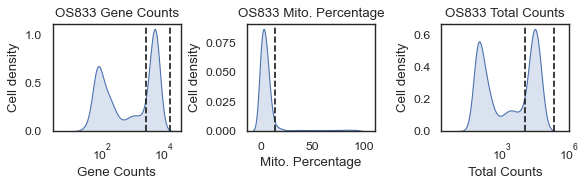

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:554: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["gene_count_corr"] = np.round(


Normalized count data: X, spliced, unspliced.


/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_57853/2697391238.py:85: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html 

    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    215 total control genes are used. (0:00:00)
computing score 'G2M_score'


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'G2M_score', score of gene set (adata.obs).
    172 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2167: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2084: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])
/Users/brendamelano/opt/

    finished (0:00:12)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


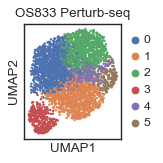

In [2]:
# Reading in H5 file
# Contains the cutoff at 9k cells
#adata = sc.read_10x_h5('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/filtered_feature_bc_matrix.h5')

# Reading in the loom file
adata = scv.read('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_pert.loom', cache = True)


# Making the var names unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'


# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


# Data for the variables
variables = [
    ('n_genes_by_counts', [(15000, '--'), (2500, '--')]),
    ('pct_counts_mt', [(14, '--')]),
    ('total_counts', [(10000, '--'), (200000, '--')])
]


# Dictionary for new titles
titles = {
    'n_genes_by_counts': 'Gene Counts',
    'pct_counts_mt': 'Mito. Percentage',
    'total_counts': 'Total Counts'
}


# Setting the theme without gridlines
sns.set_theme(style="white")


# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))


# Iterate over the variables and their respective lines to plot
for ax, (var, lines) in zip(axes, variables):
    sns.kdeplot(data=adata.obs, x=var, fill=True, alpha=0.2, ax=ax,
                log_scale=True if var != 'pct_counts_mt' else False)
    for line, style in lines:
        ax.axvline(x=line, color='k', linestyle=style)
    ax.set_title(f"OS833 {titles[var]}")  # Simpler title without extra text
    ax.set_xlabel(titles[var])  # Optionally keep the x-label as the new title
    ax.set_ylabel("Cell density")


# Adjust layout to prevent overlap
plt.tight_layout()


# Save the figure as SVG
plt.savefig("/Users/brendamelano/Desktop/OS833_perturb_filtering.svg")


# Show the plot
plt.show()


# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 10000) &
                        (adata.obs['total_counts'] <= 200000) &
                        (adata.obs['n_genes_by_counts'] >= 2500) &
                        (adata.obs['n_genes_by_counts'] < 15000) & 
                        (adata.obs['pct_counts_mt'] < 14)
                        ]


#scv.pp.filter_genes(adata, min_shared_counts=20)


# Normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# make sure that the log transformation is where it belongs in this preprocessing sequence
scv.pp.log1p(adata)

# making the adata copy below might have to go before the log transformation


# preserving the counts
adata.layers["counts"] = adata.X.copy() 


# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000, #7000 when confirming KD... previously 3000
    subset=True,
    layer="counts"
)


genes = adata.var.index.values


## Cell-cycle regression


# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]


# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]


cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)


adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']


#adata.raw = adata

# Filtering the data based on highly variable genes
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10) # comment out when confirming KD


sc.tl.pca(adata, svd_solver='arpack')


# Computing nearest neighbors
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=15)


# Computing umap analysis
sc.tl.umap(adata)


sc.tl.leiden(adata, resolution = 0.45)


# Create a figure and a set of subplots
fig, ax = plt.subplots()


# Plot the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    title="OS833 Perturb-seq",
    size=20,
    show=False,  # Prevents the immediate display of the plot
    ax=ax  # Directs the plot to the axes object created earlier
)


# Use tight_layout to adjust the spacing
plt.tight_layout()


# Save the plot as an SVG file
#plt.savefig("/Users/brendamelano/Desktop/OS833_perturbseq_umap_plot.svg", format='svg')


# After saving, you can also display the plot if you wish
plt.show()

In [9]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_perturbseq_adata_leiden_PCA.h5ad")


In [3]:
adata.obs.index

Index(['OS833_pert:AACAAAGGTACCCAGCx', 'OS833_pert:AACAACCTCAGCGCGTx',
       'OS833_pert:AAAGGTAGTAAGATACx', 'OS833_pert:AAAGTGATCATTCTTGx',
       'OS833_pert:AAACGAATCTACACTTx', 'OS833_pert:AAACGAAAGACCAAATx',
       'OS833_pert:AAAGGGCAGAAATTGCx', 'OS833_pert:AAAGTCCTCCGTGTGGx',
       'OS833_pert:AAACGCTGTCACTTAGx', 'OS833_pert:AAACCCAGTCCACATAx',
       ...
       'OS833_pert:TTTCAGTCATGATCTGx', 'OS833_pert:TTTCAGTTCGATAACCx',
       'OS833_pert:TTTGGAGGTGTATACCx', 'OS833_pert:TTTCAGTTCTCATAGGx',
       'OS833_pert:TTTACCACAATCTCTTx', 'OS833_pert:TTTACTGTCAGACAAAx',
       'OS833_pert:TTTGTTGAGAATTCAGx', 'OS833_pert:TTTCACATCAAGTAAGx',
       'OS833_pert:TTTCAGTAGGTAAGAGx', 'OS833_pert:TTTGGTTAGAGAGGTAx'],
      dtype='object', name='CellID', length=3461)

# Reading in cluster data

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


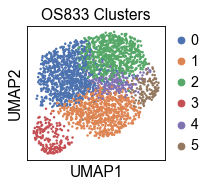

In [2]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_perturbseq_adata_leiden_PCA.h5ad")


# Plot the UMAP
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=True,
    title="OS833 Clusters",
    size=20,
    show=False  # Do not display the plot immediately
)


# Rasterize the scatter plot elements only
ax = plt.gca()
for artist in ax.get_children():
    if isinstance(artist, mc.PathCollection):
        artist.set_rasterized(True)

        
# Save as an SVG with rasterized points
#plt.savefig("/Users/brendamelano/Desktop/OS384_pert_clusters_rasterized.svg", format='svg')
plt.show()

In [3]:
adata.obs.index

Index(['AACAAAGGTACCCAGC-1', 'AACAACCTCAGCGCGT-1', 'AAAGGTAGTAAGATAC-1',
       'AAAGTGATCATTCTTG-1', 'AAACGAATCTACACTT-1', 'AAACGAAAGACCAAAT-1',
       'AAAGGGCAGAAATTGC-1', 'AAAGTCCTCCGTGTGG-1', 'AAACGCTGTCACTTAG-1',
       'AAACCCAGTCCACATA-1',
       ...
       'TTTAGTCCATAATCGC-1', 'TTTACGTGTGACGTCC-1', 'TTTCAGTCATGATCTG-1',
       'TTTGGAGGTGTATACC-1', 'TTTCAGTTCTCATAGG-1', 'TTTACTGTCAGACAAA-1',
       'TTTGTTGAGAATTCAG-1', 'TTTCACATCAAGTAAG-1', 'TTTCAGTAGGTAAGAG-1',
       'TTTGGTTAGAGAGGTA-1'],
      dtype='object', name='CellID', length=2924)

# Reading in state-labeled dataset

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<Axes: title={'center': 'OS833 States'}, xlabel='UMAP1', ylabel='UMAP2'>

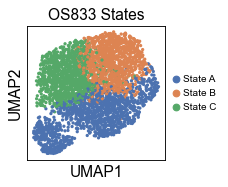

In [2]:
# Reading in the adata file from the subtype data
adata = scv.read("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_perturbseq_adata_state_labeled.h5ad")



# Plotting based on UMAP
sc.pl.umap(adata, 
           color=['State'], 
           legend_fontsize=9, 
           title="OS833 States",
           show=False)  # Prevent the figure from displaying immediately


# Save the figure manually to Desktop
#plt.savefig('/Users/brendamelano/Desktop/UMAP_OS833_State.svg', format='svg', dpi=300)

In [3]:
adata.obs.index

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_counts,S_score,G2M_score,phase,ccdifference,leiden,State
CellID,,,,,,,,,,,
OS833_pert:AACAAAGGTACCCAGCx,5681,39771.0,3544.0,8.911016,39771.0,0.229373,0.342255,G2M,-0.112882,2,State B
OS833_pert:AACAACCTCAGCGCGTx,6231,52703.0,3189.0,6.050889,52703.0,0.536766,0.701002,G2M,-0.164236,0,State C
OS833_pert:AAAGGTAGTAAGATACx,4585,21663.0,1391.0,6.421087,21663.0,0.137419,-0.017974,S,0.155393,2,State B
OS833_pert:AAAGTGATCATTCTTGx,6297,51024.0,3046.0,5.969740,51024.0,0.438880,0.801797,G2M,-0.362917,2,State B
OS833_pert:AAACGAATCTACACTTx,4057,20600.0,1658.0,8.048543,20600.0,0.297725,0.070827,S,0.226897,0,State C
...,...,...,...,...,...,...,...,...,...,...,...
OS833_pert:TTTACTGTCAGACAAAx,6143,41662.0,1793.0,4.303682,41662.0,0.451603,0.778305,G2M,-0.326702,1,State A
OS833_pert:TTTGTTGAGAATTCAGx,4088,21821.0,582.0,2.667156,21821.0,0.530196,0.134806,S,0.395390,0,State C
OS833_pert:TTTCACATCAAGTAAGx,5189,28838.0,1636.0,5.673070,28838.0,0.309504,0.513714,G2M,-0.204210,2,State B


# State module enrichment

computing score 'State_A_score'
    finished: added
    'State_A_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'State_B_score'
    finished: added
    'State_B_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score 'State_C_score'
    finished: added
    'State_C_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)


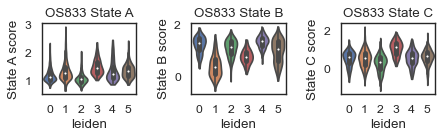

In [3]:
# Reading in gene lists for GSEA
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_A_module_NMF.csv')]
Subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_B_module_NMF.csv')]
Subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files/State_C_module_NMF.csv')]


# Keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]
Subtype_B_genes = [x for x in Subtype_B_genes if x in adata.var_names]
Subtype_C_genes = [x for x in Subtype_C_genes if x in adata.var_names]


# Computing GSEA scores
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_A_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_B_score', random_state=0, copy=False, use_raw=None)

sc.tl.score_genes(adata, Subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='State_C_score', random_state=0, copy=False, use_raw=None)

# Plotting the results
fig, axs = plt.subplots(1, 3, figsize=(5.7, 1.9))


sc.pl.violin(adata, ['State_A_score'], 
             groupby='leiden', stripplot=False, inner='box', 
             ylabel='State A score', ax=axs[0], show=False)

axs[0].set_title('OS833 State A')

sc.pl.violin(adata, ['State_B_score'], 
             groupby='leiden', stripplot=False, inner='box', 
             ylabel='State B score', ax=axs[1], show=False)

axs[1].set_title('OS833 State B')

sc.pl.violin(adata, ['State_C_score'], 
             groupby='leiden', stripplot=False, inner='box', 
             ylabel='State C score', ax=axs[2], show=False)

axs[2].set_title('OS833 State C')


plt.tight_layout()


# Saving the figure onto the desktop
#plt.savefig('/Users/brendamelano/Desktop/OS152_state_module_scores.svg', format='svg')
plt.show()

In [3]:
# Extracting the state scores
score_df = adata.obs[['leiden', 'State_A_score', 'State_B_score', 'State_C_score']].copy()


# Mean scores per cluster
mean_scores = score_df.groupby('leiden')[['State_A_score', 'State_B_score', 'State_C_score']].mean()


# Smaller rank means a higher score (rank=1 is the highest mean score)
ranked_scores = mean_scores.rank(method='dense', ascending=False, axis=0) 


# Assign each cluster the state with the highest mean state module enrichment score (same as lowest rank score)
cluster_state_assignment = ranked_scores.idxmin(axis=1)


# 
adata.obs['dominant_state'] = adata.obs['leiden'].map(cluster_state_assignment.to_dict())


cluster_state_assignment

leiden
0    State_B_score
1    State_A_score
2    State_B_score
3    State_A_score
4    State_B_score
5    State_A_score
dtype: object

In [ ]:
# GSEA per state

computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'
    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    150 total control genes are used. 

/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_78368/598534479.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45, ha='right')


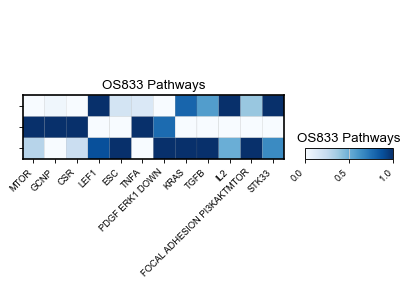

In [3]:
# Define the directory for the gmt files
directory = '/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/gmt_files'

# Create a dictionary to store gene lists
gene_lists = {}

# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

# Defining the score names
scores = ['MTOR_genes_score', 'GCNP_genes_score', 'CSR_genes_score',   
          'LEF1_genes_score', 'ESC_genes_score', 'TNFA_genes_score',
          'PDGF_ERK1_DOWN_genes_score', 'KRAS_genes_score', 'TGFB_genes_score',
          'IL2_genes_score', 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 
          'STK33_genes_score']

# Plotting the pathway matrix plot based on subtype
axes_dict = sc.pl.matrixplot(
    adata,
    scores,
    "State",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    show=False  # This prevents the plot from showing immediately
)

# Modify the x-axis and y-axis labels
for ax in axes_dict.values():
    labels = [label.get_text().replace('_genes_score', '').replace('_', ' ') for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(['' for _ in ax.get_yticklabels()])  # Remove y-axis labels
    ax.set_title('OS833 Pathways', fontsize=12)

# Save the figure. Ensure that all parts of the figure are on the same figure object
plt.gcf().savefig('/Users/brendamelano/Desktop/OS833__perturbseq_Pathways.svg', format='svg')  # Adjust path as needed

# Show the plot if desired
plt.show()

# State labeling

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


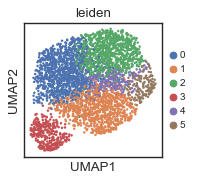

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html 

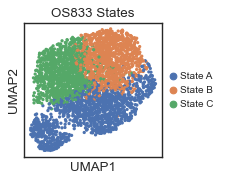

In [4]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=9, size = 20)


adata.obs['leiden'] = adata.obs['leiden'].astype('category')


# Reassigning cluster numbers
adata.obs['leiden'][adata.obs['leiden']=='4']='2'
adata.obs['leiden'][adata.obs['leiden']=='5']='1'
adata.obs['leiden'][adata.obs['leiden']=='3']='1'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'State A': ['1'],  'State B': ['2'], 'State C':['0']}


# Initialize empty column in cell metadata
adata.obs['State'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'State'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['State'].values)

# Define the number of clusters
n_subtypes = len(subtypes[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)


# Create a dictionary that maps each cluster ID to a color from the palette
#subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
#adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]

sc.pl.umap(adata, color=['State'], legend_fontsize=9, title = "OS833 States") #, palette = subtype_colors


# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_perturbseq_adata_state_labeled.h5ad")


In [5]:
adata.obs.index

Index(['OS833_pert:AACAAAGGTACCCAGCx', 'OS833_pert:AACAACCTCAGCGCGTx',
       'OS833_pert:AAAGGTAGTAAGATACx', 'OS833_pert:AAAGTGATCATTCTTGx',
       'OS833_pert:AAACGAATCTACACTTx', 'OS833_pert:AAACGAAAGACCAAATx',
       'OS833_pert:AAAGGGCAGAAATTGCx', 'OS833_pert:AAAGTCCTCCGTGTGGx',
       'OS833_pert:AAACGCTGTCACTTAGx', 'OS833_pert:AAACCCAGTCCACATAx',
       ...
       'OS833_pert:TTTCAGTCATGATCTGx', 'OS833_pert:TTTCAGTTCGATAACCx',
       'OS833_pert:TTTGGAGGTGTATACCx', 'OS833_pert:TTTCAGTTCTCATAGGx',
       'OS833_pert:TTTACCACAATCTCTTx', 'OS833_pert:TTTACTGTCAGACAAAx',
       'OS833_pert:TTTGTTGAGAATTCAGx', 'OS833_pert:TTTCACATCAAGTAAGx',
       'OS833_pert:TTTCAGTAGGTAAGAGx', 'OS833_pert:TTTGGTTAGAGAGGTAx'],
      dtype='object', name='CellID', length=3461)

# Reading in the mol_info data from wynton

In [4]:
# For loom files
adata.obs.index = adata.obs.index.str.replace('OS833_pert:', '').str.replace('x', '') + '-1'


# Reading in the macthed cell barcodes and guides that were generated in wynton
molecular_data = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_molecular_data.csv', index_col=0) 


# Keep only the 'feature_ids' and 'cell_barcodes' columns
molecular_data = molecular_data[['feature_ids', 'cell_barcodes']]


# Removing the b'' string
molecular_data['feature_ids'] = molecular_data['feature_ids'].str.strip("b''")


molecular_data['feature_ids'] = molecular_data['feature_ids'].str.replace(r'(-1i|-2i)$', '', regex=True)

# removing the b'' string from cell barcodes
molecular_data['cell_barcodes'] = molecular_data['cell_barcodes'].str.strip("b''")
# Remove duplicate rows across the entire DataFrame
molecular_data_unique = molecular_data.drop_duplicates()

molecular_data_unique['cell_barcodes'] = molecular_data_unique['cell_barcodes'].apply(lambda x: f"{x}-1")


molecular_data_unique = molecular_data_unique.set_index('cell_barcodes')

adata.obs = adata.obs.assign(cell_barcode=adata.obs.index)

adata.obs['Gene'] = "NT-ctrl"


for barcode in molecular_data_unique.index:
    if barcode in adata.obs.index:
        # If barcode exists in AnnData, add/update gene info in .obs
        # Example: Add a concatenated string of genes to a new column, handling duplicates
        genes = molecular_data_unique.loc[barcode, 'feature_ids']
        gene_str = ', '.join(genes) if isinstance(genes, pd.Series) else genes
        adata.obs.at[barcode, 'Gene'] = gene_str
    else:
        # If barcode does not exist, add a new entry (optional, depends on your analysis needs)
        # You might need to handle adding new cells to `.X` or other attributes depending on your data structure
        genes = 'NT-ctrl'
        
        
# Filter observations where 'Gene' column does not contain a comma
adata = adata[~adata.obs['Gene'].str.contains(',')].copy()


# Convert 'feature_ids' column to string
#adata['feature_ids'] = adata['feature_ids'].astype(str)

# Filter rows where 'feature_ids' column contains the string "LT"
#filtered_data = merged_data[merged_data['feature_ids'].str.contains("LT", na=False)]



# Define a function that replaces any string containing 'control' with 'control'
def replace_with_control(gene_string):
    if 'control' in gene_string:
        return 'control'
    else:
        return gene_string

# Apply the function to the 'Gene' column
adata.obs['Gene'] = adata.obs['Gene'].apply(replace_with_control)


# Define a function that replaces any string containing 'control' with 'control'
def replace_with_control(gene_string):
    if 'NT-ctrl' in gene_string:
        return 'NT-ctrl'
    else:
        return gene_string

# Apply the function to the 'Gene' column
adata.obs['Gene'] = adata.obs['Gene'].apply(replace_with_control)

# Define a function that replaces any string containing 'control' with 'control'
def replace_with_control(gene_string):
    if 'control' in gene_string:
        return 'NT-ctrl'
    else:
        return gene_string

# Apply the function to the 'Gene' column
adata.obs['Gene'] = adata.obs['Gene'].apply(replace_with_control)

kd_counts = adata.obs['Gene'].value_counts()

# Printing the counts
print(kd_counts)


NT-ctrl    2057
IRF1        186
NFE2L3      158
TCF4        107
NFKB2       107
TSHZ2        81
JUN          78
NR0B1        73
STAT1        70
JUNB          7
Name: Gene, dtype: int64


# State and target dataframe

In [5]:
# Extracting the required columns
df = adata.obs[['Gene', 'State']]


# Creating one-hot encoding for the Gene column
one_hot = pd.get_dummies(df['Gene'])
df = df.join(one_hot)



# Adding a 'cell_line' column with all values as 'OS384'
df['cell_line'] = 'OS833'


df = df.drop(columns=['Gene'])


# Saving the DataFrame
df.to_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_Subtype_target_for_modeling.csv')


# Reading the DataFrame back in to ensure it was saved correctly
loaded_df = pd.read_csv('/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/Perturb_seq_analysis/OS833/OS833_Subtype_target_for_modeling.csv', index_col='CellID')


loaded_df

,State,IRF1,JUN,JUNB,NFE2L3,NFKB2,NR0B1,NT-ctrl,STAT1,TCF4,TSHZ2,cell_line
CellID,,,,,,,,,,,,
AACAAAGGTACCCAGC-1,State B,0,0,0,1,0,0,0,0,0,0,OS833
AACAACCTCAGCGCGT-1,State C,0,0,0,0,0,0,0,0,1,0,OS833
AAAGGTAGTAAGATAC-1,State B,0,0,0,0,0,0,1,0,0,0,OS833
AAAGTGATCATTCTTG-1,State B,0,0,0,0,0,0,1,0,0,0,OS833
AAACGAATCTACACTT-1,State C,0,0,0,0,0,1,0,0,0,0,OS833
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTACTGTCAGACAAA-1,State A,0,0,0,0,0,0,1,0,0,0,OS833
TTTGTTGAGAATTCAG-1,State C,0,0,0,0,0,0,1,0,0,0,OS833
TTTCACATCAAGTAAG-1,State B,1,0,0,0,0,0,0,0,0,0,OS833


# state markers by cluster

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/var/folders/lt/nhcx288j6jjfg45n3bhh1mjh0000gn/T/ipykernel_62098/2149357141.py:49: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_subset.var['subtype_order'] = adata_subset.var['State'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


<Figure size 1200x300 with 0 Axes>

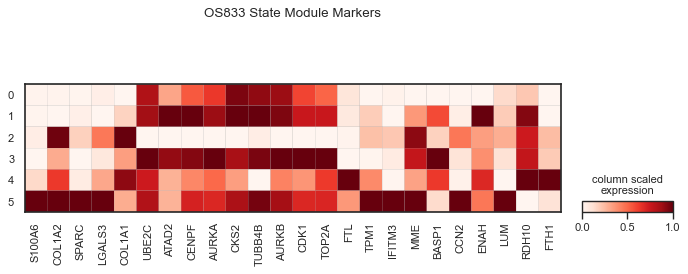

In [7]:
# Read gene lists for each subtype from the CSV files
def read_genes(file_path):
    with open(file_path, 'r') as file:
        genes = [x.strip() for x in file]
    return genes


# Reading in the subtype gene modules
Subtype_A_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')
Subtype_B_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')
Subtype_C_genes = read_genes('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')


# Specified markers for visualization
specified_genes = ['UBE2C', 'AURKA', 'CENPF', 'AURKB', 'CKS2', 'TOP2A', 'CDK1', 'TUBB4B', 'ATAD2', 'H2AX']


# Ensure these genes are in the adata object
reduced_state_B_genes = [gene for gene in specified_genes if gene in adata.var_names]


plt.rcParams.update({'font.size': 12})


# Combine gene lists from all subtypes, ensuring uniqueness if necessary
combined_genes = list(set(Subtype_A_genes + reduced_state_B_genes + Subtype_C_genes))


# Keeping only genes that appear in the adata object
combined_genes = [gene for gene in combined_genes if gene in adata.var_names]


# Ensure the combined_genes are in your expression data
adata_subset = adata[:, adata.var_names.isin(combined_genes)]


# Create the subtype dictionary 
subtype_A_dict = {gene: 'A' for gene in Subtype_A_genes}
subtype_B_dict = {gene: 'B' for gene in reduced_state_B_genes}
subtype_C_dict = {gene: 'C' for gene in Subtype_C_genes}
subtype_dict = {**subtype_A_dict, **subtype_B_dict, **subtype_C_dict}


# Annotate the genes in adata with their subtype
adata.var['State'] = [subtype_dict.get(gene, 'Unknown') for gene in adata.var_names]


# Sort the genes in your subset by subtype
adata_subset = adata[:, adata.var_names.isin(combined_genes)]
adata_subset.var['subtype_order'] = adata_subset.var['State'].map({'A': 1, 'B': 2, 'C': 3, 'Unknown': 4})
adata_subset = adata_subset[:, adata_subset.var['subtype_order'].argsort()]


# Create a list of genes sorted by subtype for use in the matrixplot
sorted_genes_by_subtype = adata_subset.var_names.tolist()


# Create a figure explicitly
plt.figure(figsize=(2, 0.5), dpi=600) 


ax = sc.pl.matrixplot(
    adata_subset,
    var_names=sorted_genes_by_subtype,  # Use the sorted list of genes
    groupby='leiden',
    cmap="Reds",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
    title="OS833 State Module Markers",
    show=False
)


# Save the figure using matplotlib's savefig with explicit format setting
#plt.savefig("/Users/brendamelano/Desktop/OS833_cluster_markers_perturb.svg", format='svg')

plt.show()

plt.close()


# RNA velocity

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/497 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:02:26) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3461 [00:00<?, ?cells/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


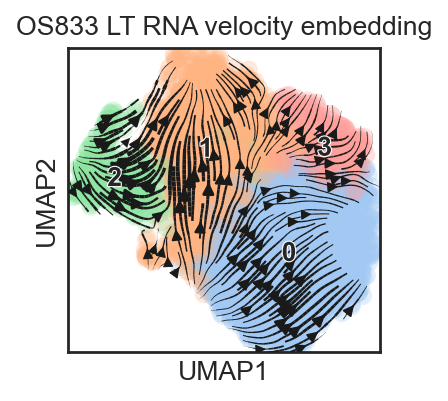

In [7]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)


# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')


# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden', 
                                 palette=colors, title = 'OS833 LT RNA velocity embedding',
                                frameon = True)

# Testing KD

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


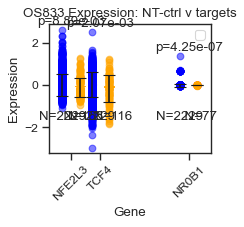

In [3]:
###  MUST REMOVE SCALING AND INCREASE THE NUMBER OF VARIABLE GENES USED TO 5-6K


valid_genes = [gene for gene in kd_counts.index if gene in adata.var_names]

p_values = []

# Iterate over each valid gene to plot
for i, gene in enumerate(valid_genes):
    adata_ctrl = adata[adata.obs['Gene'] == 'NT-ctrl']
    adata_gene = adata[adata.obs['Gene'] == gene]

    ctrl_expression = adata_ctrl[:, gene].X.flatten()
    gene_expression = adata_gene[:, gene].X.flatten()

    control_mean = np.mean(ctrl_expression)
    control_std = np.std(ctrl_expression)
    gene_mean = np.mean(gene_expression)
    gene_std = np.std(gene_expression)

    # Perform Welch's t-test
    t_stat, p_value = ttest_ind(ctrl_expression, gene_expression, equal_var=False)
    p_values.append(p_value)

# Adjust p-values for multiple comparisons using the Benjamini-Hochberg procedure
from statsmodels.stats.multitest import multipletests
rejections, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')


# Assuming valid_genes and corrected_p_values are defined from previous steps
significance_threshold = 0.05

# Get the indices of significant genes for plotting purposes
significant_indices = [i for i, p_val in enumerate(corrected_p_values) if p_val < significance_threshold]


from scipy.stats import ttest_ind

plt.figure(figsize=(3, 3))

# Plot only significant genes
for i in significant_indices:
    # Indices and gene names correspond to significant genes only
    gene = valid_genes[i]
    adata_ctrl = adata[adata.obs['Gene'] == 'NT-ctrl']
    adata_gene = adata[adata.obs['Gene'] == gene]

    ctrl_expression = adata_ctrl[:, gene].X.flatten()
    gene_expression = adata_gene[:, gene].X.flatten()

    control_mean = np.mean(ctrl_expression)
    control_std = np.std(ctrl_expression)
    gene_mean = np.mean(gene_expression)
    gene_std = np.std(gene_expression)
    n_control = len(ctrl_expression)
    n_gene = len(gene_expression)

    # Perform Welch's t-test
    t_stat, p_value = ttest_ind(ctrl_expression, gene_expression, equal_var=False)

    # Create bars for the mean expression levels
    plt.bar(i - 0.3, control_mean, yerr=control_std, capsize=5, width=0.4, color='blue', label='NT-ctrl' if i == 0 else "")
    plt.bar(i + 0.3, gene_mean, yerr=gene_std, capsize=5, width=0.4, color='orange', label=gene if i == 0 else "")

    # Add individual data points
    plt.scatter([i - 0.3] * n_control, ctrl_expression, color='blue', alpha=0.5)
    plt.scatter([i + 0.3] * n_gene, gene_expression, color='orange', alpha=0.5)

    # Annotate the plot with p-values offset from the highest point in the plot
    y_offset = 0.1  # Adjust this value as needed to offset the p-value text
    max_expression = max(max(ctrl_expression), max(gene_expression))
    plt.text(i, max_expression + y_offset, f'p={p_value:.2e}', ha='center', va='bottom')
    

import matplotlib.pyplot as plt



# Add cell count information at the bottom of the plot
for i in significant_indices:
    gene = valid_genes[i]
    n_control = sum(adata.obs['Gene'] == 'NT-ctrl')
    n_gene = sum(adata.obs['Gene'] == gene)
    plt.text(i - 0.3, -1.2, f'N={n_control}', ha='center', va='top')
    plt.text(i + 0.3, -1.2, f'  N={n_gene}', ha='center', va='top')

# Set the x-ticks to correspond to significant genes only
plt.xticks(significant_indices, [valid_genes[i] for i in significant_indices], rotation=45)

# Set labels and title
plt.xlabel('Gene')
plt.ylabel('Expression')
plt.legend()
plt.title('OS833 Expression: NT-ctrl v targets')

# Adjust layout
plt.tight_layout()

# Save the plot as SVG
plt.savefig('/Users/brendamelano/Desktop/OS833_Target_Gene_KD_test.svg', format='svg')

plt.show()

# After saving, return the path to the saved SVG file
#plot_path = '/mnt/data/plot.svg'
#plot_path


In [8]:
def plot_gene_expression(adata, gene, output_path=None):
    """
    Generates box plot and density plot for a given gene using the specified AnnData object.

    Parameters:
    adata (AnnData): The annotated data matrix.
    gene (str): Target gene to plot.
    output_path (str): Optional path to save the plots as SVG files. If None, plots are displayed instead.
    """
    # Check if the gene is present in the dataset
    if gene not in adata.var_names:
        raise ValueError(f"Gene '{gene}' not found in the AnnData object.")
    
    # Separate the control and gene-specific data
    adata_ctrl = adata[adata.obs['Gene'] == 'NT-ctrl']
    adata_gene = adata[adata.obs['Gene'] == gene]

    # Extract expression values for the target gene
    ctrl_expression = adata_ctrl[:, gene].X.flatten()
    gene_expression = adata_gene[:, gene].X.flatten()

    # Ensure non-empty data
    if len(ctrl_expression) == 0 or len(gene_expression) == 0:
        raise ValueError("Expression data is empty for one of the groups.")
    
    # Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(ctrl_expression, gene_expression, alternative='two-sided')

    # Prepare data for box plot
    data_to_plot = [ctrl_expression, gene_expression]

    # Box Plot
    plt.figure(figsize=(3, 2.5))
    plt.boxplot(data_to_plot, widths=0.4, patch_artist=True,
                medianprops={'color': 'black'},
                boxprops={'facecolor': 'lightblue'},
                whiskerprops={'color': 'blue'},
                capprops={'color': 'blue'})
    
    # Customize plot with labels
    plt.xticks([1, 2], ['NT-ctrl', gene])
    plt.xlabel('Group')
    plt.ylabel('Expression Levels')
    plt.title(f'{gene} Expression')
    
    # Annotate with p-value
    plt.text(1.5, max(np.concatenate(data_to_plot)) - 0.2, f'p-value = {p_value:.2e}', ha='center', va='bottom')
    plt.tight_layout()
    
    # Save box plot if path is provided
    if output_path:
        plt.savefig(f'{output_path}/{gene}_expression_boxplot.svg', format='svg')
    else:
        plt.show()

    plt.close()

    # Histogram / Density Plot
    plt.figure(figsize=(2.2, 2.3))

    # Create density plots
    sns.kdeplot(ctrl_expression, color='skyblue', fill=True, alpha=0.5, label='NT-ctrl')
    sns.kdeplot(gene_expression, color='lightpink', fill=True, alpha=0.5, label=gene)

    plt.title(f'Density Plot for {gene}')
    plt.xlabel('Expression Level')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()

    # Save density plot if path is provided
    if output_path:
        plt.savefig(f'{output_path}/{gene}_density_plot.svg', format='svg')
    else:
        plt.show()

    plt.close()
    
    
# Assuming 'adata' is your AnnData object and 'NFE2L3' is the gene of interest
plot_gene_expression(adata, 'NR0B1', output_path='/Users/brendamelano/Desktop')

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2250: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  dtyp = np.find_common_type([x.dtype, np.float64], [])


# Cluster proportions by guide

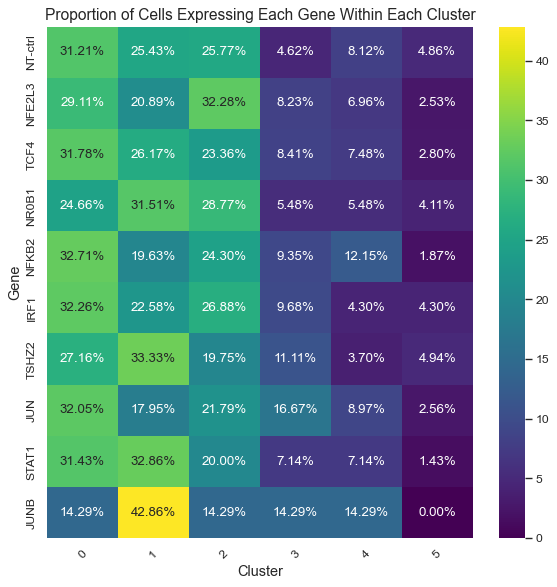

In [6]:
clusters_sorted = sorted(adata.obs['leiden'].unique())
gene_clusters = pd.DataFrame(columns=clusters_sorted)

# First, ensure 'NT-ctrl' is included at the beginning of the genes list
unique_genes = np.append('NT-ctrl', adata.obs['Gene'].unique())

# Fill the DataFrame
for gene in unique_genes:
    percentages = []
    gene_total = (adata.obs['Gene'] == gene).sum()  # Total cells expressing the gene across all clusters
    if gene_total == 0:  # Handle 'NT-ctrl' and any gene not found to avoid division by zero
        percentages = [0 for _ in clusters_sorted]
    else:
        for cluster in clusters_sorted:
            gene_in_cluster = ((adata.obs['Gene'] == gene) & (adata.obs['leiden'] == cluster)).sum()
            prop_gene_in_cluster = gene_in_cluster / gene_total  # Proportion of cells in this cluster for the gene
            percentages.append(prop_gene_in_cluster)
    gene_clusters.loc[gene] = percentages

# Convert to percentages
gene_clusters *= 100

# Convert each value to a string with a percentage sign for annotation
gene_clusters_str = gene_clusters.applymap(lambda x: "{:.2f}%".format(x))

# Plotting the heatmap
plt.figure(figsize=(7.5,7.5))
sns.heatmap(gene_clusters, annot=gene_clusters_str, fmt="s", cmap='viridis')
plt.title('Proportion of Cells Expressing Each Gene Within Each Cluster', fontsize=14)
plt.ylabel('Gene', fontsize=13)
plt.xlabel('Cluster', fontsize=13)
plt.xticks(rotation=45)
plt.tight_layout()

# Adjust the file path for saving the figure as needed
#plt.savefig('/Users/brendamelano/Desktop/OS384_Percent_in_cluster_per_target.svg', format='svg')
plt.show()

# Visualizing cells from a certain target

In [16]:
adata.obs['TCF4'] = pd.Categorical(adata.obs['Gene'].apply(lambda x: 1 if x == 'TCF4' else 0))


adata = adata[adata.obs['TCF4'].sort_values(ascending=False).index]


# Define a custom color palette where 'False' is gray and 'True' is the default color (e.g., orange)
custom_palette = ['#808080', 'orange']  # gray for 'False', orange for 'True'


# Reorder data so that 'True' values are plotted last (on top)
adata_temp = adata[adata.obs['TCF4'].sort_values().index]
# Plot the UMAP with the custom color palette and increased dot size
sc.pl.umap(adata_temp, color='TCF4', palette=custom_palette, 
           add_outline=True, s=30, title='OS384 TCF4 perturbed cells')

# ,        save = "OS384_depleted_barcodes.svg"

# DGEA

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devd

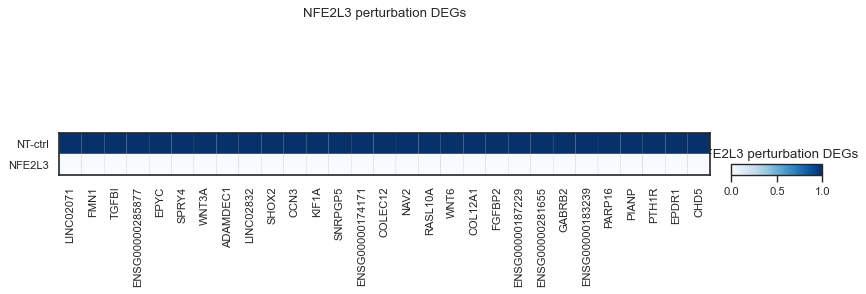

In [3]:
def perform_dge_analysis_and_visualize_heatmap(adata, gene_of_interest, control='NT-ctrl', output_file='/Users/brendamelano/Desktop/heatmap.svg'):
    # Filter the data for the specified gene and control
    adata_filtered = adata[adata.obs['Gene'].isin([control, gene_of_interest])].copy()

    # Create a grouping variable
    adata_filtered.obs['group'] = adata_filtered.obs['Gene']

    # Perform differential gene expression analysis directly comparing 'control' vs the specified gene
    sc.tl.rank_genes_groups(adata_filtered, groupby='group', groups=[gene_of_interest], reference=control)

    # Access the differential expression results
    results = adata_filtered.uns['rank_genes_groups']

    # Extract the names, log fold changes, and p-values for the specified gene group
    gene_names = results['names'][gene_of_interest]
    logfoldchanges = results['logfoldchanges'][gene_of_interest]
    pvals = results['pvals'][gene_of_interest]
    pvals_adj = results['pvals_adj'][gene_of_interest]

    # Create a DataFrame
    df = pd.DataFrame({
        'Gene': gene_names,
        'Log2 fold change': logfoldchanges,
        'P-value': pvals,
        'Adjusted P-value': pvals_adj
    })

    # Filter the DataFrame for significant log fold changes and adjusted p-values
    significant_genes = df[((df['Log2 fold change'] > 1) | (df['Log2 fold change'] < -1)) & (df['Adjusted P-value']< 0.05)]

    # Check if significant_genes is empty
    if significant_genes.empty:
        print("No significant genes found with the given criteria.")
        return df  # Return the full dataframe for further inspection

    # Normalize the data
    sc.pp.scale(adata_filtered)

    # Ensure only the specified groups are included
    adata_filtered.obs['group'] = pd.Categorical(
        adata_filtered.obs['group'],
        categories=[control, gene_of_interest]
    )

    # Create the matrixplot for all genes in the group
    ax = sc.pl.matrixplot(
        adata_filtered,
        var_names=significant_genes['Gene'],
        groupby='group',
        cmap="Blues",
        standard_scale="var",
        colorbar_title="column scaled\nexpression",
        title=f"{gene_of_interest} perturbation DEGs",
        show=False  # Do not display the plot immediately
    )

    # Set the title
    plt.title(f"{gene_of_interest} perturbation DEGs")

    # Save the plot as an SVG file
    plt.savefig(output_file, format='svg')

    # Show the plot
    plt.show()

    return significant_genes



In [ ]:

significant_genes = perform_dge_analysis_and_visualize_heatmap(adata, gene_of_interest='NFE2L3')

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/algorithms.py:518: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


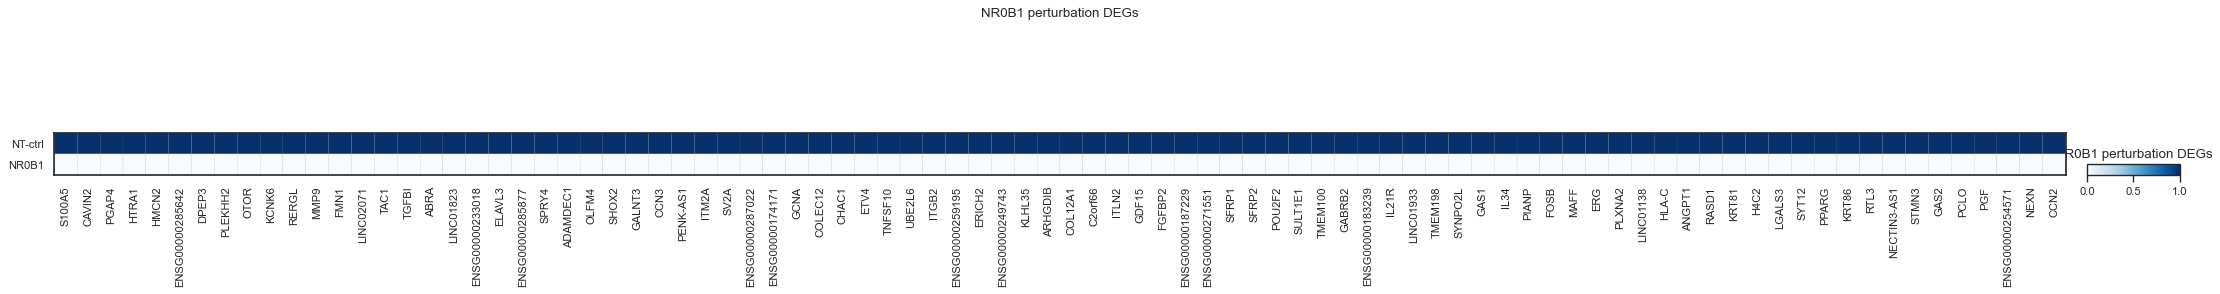

In [4]:

significant_genes = perform_dge_analysis_and_visualize_heatmap(adata, gene_of_interest='NR0B1')